In [3]:
!pip install gif
!wget https://raw.githubusercontent.com/qzheng75/PyTorch-bootcamp/main/1-Lecture-one-files/gif_utils.py
!pip install graphviz
import gif_utils
import gif
from IPython.display import Image, display
import tqdm
import matplotlib.pyplot as plt

--2025-10-22 15:16:45--  https://raw.githubusercontent.com/qzheng75/PyTorch-bootcamp/main/1-Lecture-one-files/gif_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1591 (1.6K) [text/plain]
Saving to: ‘gif_utils.py’

gif_utils.py        100%[===================>]   1.55K  --.-KB/s    in 0s      

2025-10-22 15:16:45 (32.2 MB/s) - ‘gif_utils.py’ saved [1591/1591]



In [4]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm


In [5]:
# Load the Auto MPG dataset
data = fetch_openml(name='autoMpg', version=3, parser='auto')
X = data.data
y = data.target

In [6]:
X.shape,y.shape

((392, 5), (392,))

In [7]:
X.head(5)

,Displacement,Horse_power,Weight,Acceleration,Model_year
0,91.0,70,1955,20.5,71
1,232.0,100,2789,15.0,73
2,350.0,145,4055,12.0,76
3,318.0,140,4080,13.7,78
4,113.0,95,2372,15.0,70


In [8]:
y.head(5)

,Mpg
0,26.0
1,18.0
2,13.0
3,17.5
4,24.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((294, 5), (98, 5), (294,), (98,))

In [11]:
print ("Number of datapoints in the training set:",X_train.shape[0])
print ("Number of datapoints in the test set:",X_test.shape[0])

Number of datapoints in the training set: 294
Number of datapoints in the test set: 98


In [12]:
# Standard scaling makes training stabler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
X_train = scaler.fit_transform(X_train) # We get mean and std from only train data
X_test = scaler.transform(X_test)

In [13]:
# Turn numpy arrays to torch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [14]:
# Define a more customized MLP model. One round of forward pass. 
from torch import nn

class MLP(nn.Module):
  def __init__(self, input_dim=1, hidden_dims=None, output_dim=1):
    super(MLP, self).__init__()

    if hidden_dims is None:
      hidden_dims = [32, 32]

    layers = []
    dims = [input_dim] + hidden_dims + [output_dim]

    for i in range(len(dims) - 1):
      layers.append(nn.Linear(dims[i], dims[i+1]))
      if i < len(dims) - 2:
        layers.append(nn.ReLU())

    self.mlp = nn.Sequential(*layers)

  def forward(self, X):
    return self.mlp(X)

In [15]:
net = MLP(input_dim=5, hidden_dims=[5, 10, 10])
# Push model parameters onto GPU
if torch.cuda.is_available():
  net = net.cuda()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [16]:
X_train, y_train = X_train.cuda(), y_train.cuda()
X_test, y_test = X_test.cuda(), y_test.cuda()

In [17]:
#training loops. Define hyperparameters. 
epochs = 50
best_loss = float('inf')
best_model = None

train_losses= []
val_losses = []

for epoch in tqdm.tqdm(range(epochs)):
    X_train, y_train = X_train.cuda(), y_train.cuda() # Push data to cuda
    out = net(X_train)
    loss = loss_fn(out, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print ("Training Loss:", loss.item())
    train_losses.append(loss.item())
  # Evaluate the model with the Test set


    net.eval() # Set model to evaluation mode
    with torch.no_grad():
        X_test, y_test = X_test.cuda(), y_test.cuda() # Push data to cuda
        out = net(X_test)
        loss = loss_fn(out, y_test)
        val_losses.append(loss.item())
        #no backpropagation in eveluation step


100%|██████████| 50/50 [00:00<00:00, 83.70it/s]


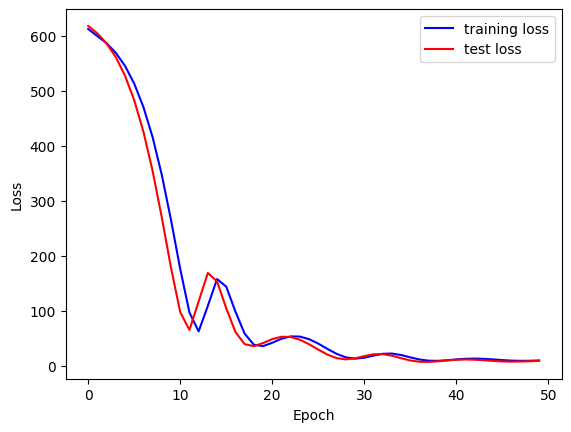

In [18]:
plt.plot(train_losses,color='blue',label='training loss')
plt.plot (val_losses,color='red',label='test loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [19]:
#have to be reshaped and detached from gpu to cpu 
y_pred_test=net(X_test)
y_pred_test=y_pred_test.detach().cpu().numpy().reshape(-1)
y_test=y_test.detach().cpu().numpy().reshape(-1)


Test MSE: 9.502176284790039
Test MAE: 2.3542256355285645
Test R2: 0.8097872138023376


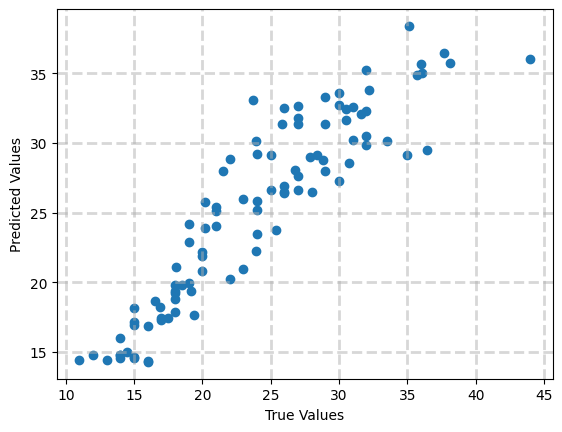

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# we can measure model performance with multiple error metrics
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"Test R2: {r2_score(y_test, y_pred_test)}")

plt.scatter(y_test,y_pred_test)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(lw=2,ls="--",alpha=0.5)
plt.show()

In [21]:
#Minibatching. # Load the Auto MPG dataset
data = fetch_openml(name='autoMpg', version=3, parser='auto')
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
X_train = scaler.fit_transform(X_train) # We get mean and std from only train data
X_test = scaler.transform(X_test)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)



In [22]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [23]:
# Create dataloaders to turn data into batches
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
for idx, (X, y) in enumerate(train_loader):
  print(f"Batch {idx}: X has shape: {X.shape}, y has shape {y.shape}")

Batch 0: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 1: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 2: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 3: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 4: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 5: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 6: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 7: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 8: X has shape: torch.Size([32, 5]), y has shape torch.Size([32, 1])
Batch 9: X has shape: torch.Size([6, 5]), y has shape torch.Size([6, 1])


In [25]:
net = MLP(input_dim=5, hidden_dims=[16, 32, 32])
# Push model parameters onto GPU
if torch.cuda.is_available():
  net = net.cuda()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

New best model at epoch 0 with training loss 311.459 and validation loss 81.507
New best model at epoch 1 with training loss 67.006 and validation loss 28.077
New best model at epoch 2 with training loss 21.460 and validation loss 17.667
New best model at epoch 3 with training loss 10.914 and validation loss 9.331
New best model at epoch 4 with training loss 9.830 and validation loss 7.353
New best model at epoch 11 with training loss 9.651 and validation loss 7.255
New best model at epoch 13 with training loss 12.882 and validation loss 6.466
New best model at epoch 41 with training loss 7.464 and validation loss 6.413


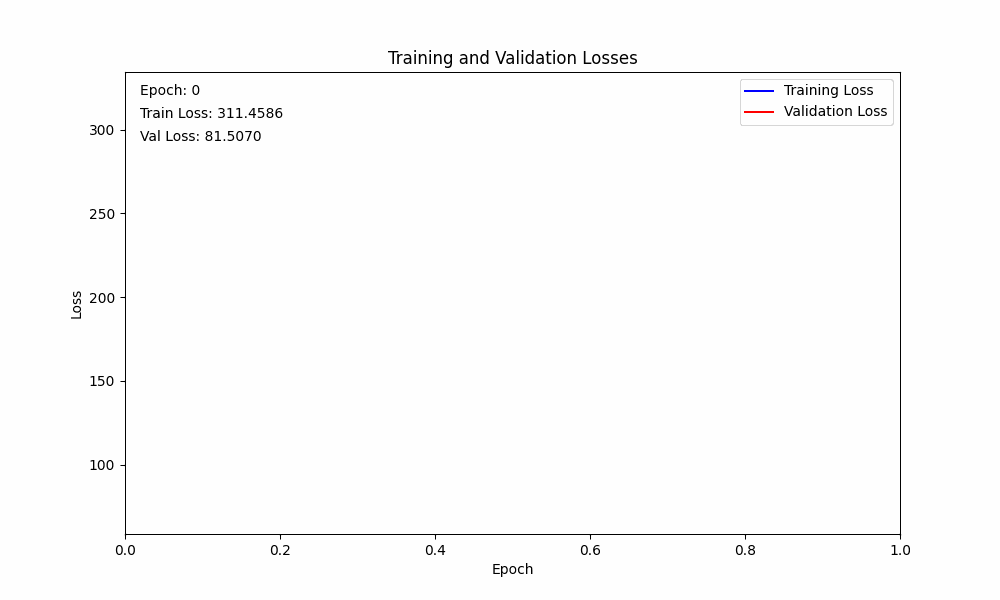

In [26]:
# Now we perform training in a batching manner
epochs = 50
best_loss = float('inf')
best_model = None

train_loss_hist = []
val_loss_hist = []
frames = []

for epoch in range(epochs):
  net.train()
  train_losses = []
  for X, y in train_loader:
    if torch.cuda.is_available():
      X, y = X.cuda(), y.cuda() # Push data to cuda
    out = net(X)
    loss = loss_fn(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  # Evaluate the model with the validation set
  val_losses = []
  net.eval() # Set model to evaluation mode
  with torch.no_grad():
    for X, y in test_loader:
      if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda() # Push data to cuda
      out = net(X)
      loss = loss_fn(out, y)
      val_losses.append(loss.item())

  avg_train_loss = np.mean(train_losses)
  avg_val_loss = np.mean(val_losses)
  train_loss_hist.append(avg_train_loss)
  val_loss_hist.append(avg_val_loss)
  frames.append(gif_utils.plot_losses(train_loss_hist, val_loss_hist, epoch))

  if avg_val_loss < best_loss:
    best_loss = avg_val_loss
    best_model = net.state_dict().copy()
    print(f"New best model at epoch {epoch} with training loss {avg_train_loss:.3f} and validation loss {best_loss:.3f}")

gif.save(frames, "mpg_mlp.gif", duration=1000)
display(Image(filename='mpg_mlp.gif'))

In [27]:
#How do gradients and backprop actually work?
#Computation graph
import graphviz
import gif
from IPython import display
import matplotlib.pyplot as plt
import torch

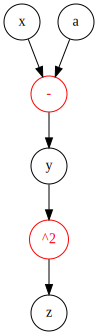

In [28]:
# Example of computation graph for MSE loss

dot = graphviz.Digraph('DAG', comment='DAG')
dot.node('x', label='x', color='black', shape='circle')
dot.node('a', label='a', color='black', shape='circle')
dot.node('-', label='-', fontcolor='red', color='red', shape='circle')
dot.node('y', label='y', color='black', shape='circle')
dot.node('sq', label='^2', fontcolor='red', color='red', shape='circle')
dot.node('z', label='z', color='black', shape='circle')

dot.edge('x','-')
dot.edge('a','-')
dot.edge('-','y')
dot.edge('y','sq')
dot.edge('sq','z')

dot.render('dag_graph', view=True)

display.display(dot)
#print(dot.source)

In [29]:
#Directed Acyclic Graphs
# These tensors form the leaves. By default all subsequently generated intermediate tensors will have requires_grad=True
x = torch.tensor(0, dtype=torch.float32, requires_grad=True)
a = torch.tensor(5, dtype=torch.float32, requires_grad=True)
y = x - a
# By default pytorch wont retain the gradients of non leaf tensors.
y.retain_grad()
z = y.pow(2)
z.retain_grad()

# Now lets compute dz/dy, dz/dx and dz/da.
# We do this by calling the backward() on the root node which accumulates the
# gradients into all leaf nodes and non leaf tensors if retain_grad() is specified.
z.backward()



In [30]:
print(f'dz/dz = {z.grad}')
print('z = y^2')
print(f'dz/dy = {y.grad}')
print('y = x - a')
print(f'dz/da = (dz/dy)*(dy/da) = {a.grad}')
print(f'dz/dx = (dz/dy)*(dy/dx) = {x.grad}')

dz/dz = 1.0
z = y^2
dz/dy = -10.0
y = x - a
dz/da = (dz/dy)*(dy/da) = 10.0
dz/dx = (dz/dy)*(dy/dx) = -10.0


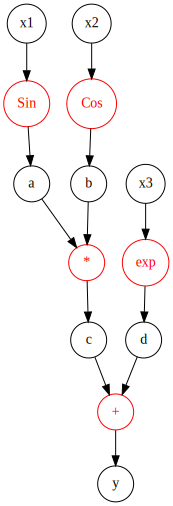

In [31]:
# Example of computation graph for MSE loss

dot = graphviz.Digraph('DAG', comment='DAG')
dot.node('x1', label='x1', color='black', shape='circle')
dot.node('x2', label='x2', color='black', shape='circle')
dot.node('x3', label='x3', color='black', shape='circle')
dot.node('Sin', label='Sin', fontcolor='red', color='red', shape='circle')
dot.node('Cos', label='Cos', fontcolor='red', color='red', shape='circle')
dot.node('a', label='a', color='black', shape='circle')
dot.node('b', label='b', color='black', shape='circle')
dot.node('*', label='*', fontcolor='red', color='red', shape='circle')
dot.node('+', label='+', fontcolor='red', color='red', shape='circle')
dot.node('c', label='c', color='black', shape='circle')
dot.node('exp', label='exp', fontcolor='red', color='red', shape='circle')
dot.node('d', label='d', color='black', shape='circle')
dot.node('y', label='y', color='black', shape='circle')

dot.edge('x1','Sin')
dot.edge('x2','Cos')
dot.edge('Sin','a')
dot.edge('Cos','b')
dot.edge('a','*')
dot.edge('b','*')
dot.edge('*','c')
dot.edge('x3','exp')
dot.edge('exp','d')
dot.edge('d','+')
dot.edge('c','+')
dot.edge('+','y')

dot.render('dag_graph', view=True)

display.display(dot)
#print(dot.source)

In [32]:
import torch
# Implementation in PyTorch

x1 = torch.tensor(1, dtype=torch.float32, requires_grad=True)
x2 = torch.tensor(2, dtype=torch.float32, requires_grad=True)
x3 = torch.tensor(3, dtype=torch.float32, requires_grad=True)

a = torch.sin(x1)
#a.retain_grad()
b = torch.cos(x2)
#b.retain_grad()

c = a*b
#c.retain_grad()

d = torch.exp(x3)
#d.retain_grad()

y = c + d

y.backward()



In [33]:

a.detach()

tensor(0.8415)

In [34]:
print(a)

tensor(0.8415, grad_fn=<SinBackward0>)


In [35]:
print(f'dy/dx1 = {x1.grad}')
print(f'dy/dx2 = {x2.grad}')
print(f'dy/dx3 = {x3.grad}')

dy/dx1 = -0.22484511137008667
dy/dx2 = -0.7651473879814148
dy/dx3 = 20.08553695678711


In [36]:
#Gradient descent
!git clone https://github.com/BughdaryanAram/labeled_micrograd.git
!cd labeled_micrograd && pip install .

Cloning into 'labeled_micrograd'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 102 (delta 41), reused 38 (delta 38), pack-reused 40 (from 1)
Receiving objects: 100% (102/102), 259.25 KiB | 25.92 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Processing /content/labeled_micrograd
  Preparing metadata (setup.py) ... done
  Created wheel for micrograd: filename=micrograd-0.1.0-py3-none-any.whl size=5039 sha256=29289fd0e77f7f1d6277622520164b2587932f29b8f8c8a002b8cbe24398e3f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-7gsp2yyt/wheels/a9/b9/c0/1a12bc25fdba992b87db03ae2c34e9f6ffd420414779f781b6
Successfully built micrograd


In [37]:
from labeled_micrograd.micrograd.engine import Value

In [38]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [39]:
# Step 1: Initialize the variables
W1 = Value(1, label='W1')
x1 = Value(-3, label='x1')

W2 = Value(2, label='W2')
x2 = Value(5, label='x2')

b = Value(6, label='b')

y_true = Value(-5, label='y_true')

W1x1 = W1 * x1
W1x1.label = 'W1*x1'

W2x2 = W2 * x2
W2x2.label = 'W2*x2'

w1x1w2x2 = W1x1 + W2x2
w1x1w2x2.label = 'W1x1+W2x2'

w1x1w2x2b = w1x1w2x2 + b
w1x1w2x2b.label = 'W1x1+W2x2+b'


y = w1x1w2x2b.relu()
y.label = 'y'

loss = y + y_true
loss.label = 'loss'

loss.backward()


print(f'{loss.data:.4f}')


8.0000


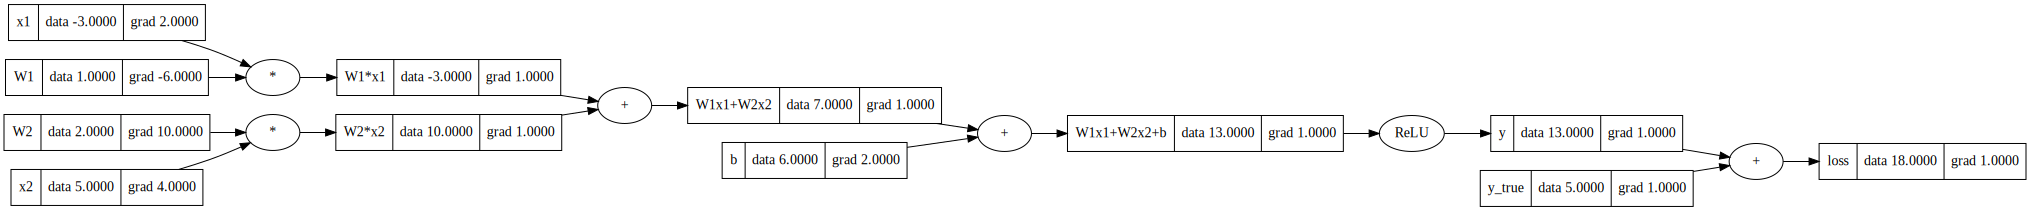

In [40]:
#Exercise 0: we can we change value of W2 (initially W2=2) so that the value of loss decrease?
# W1 = Value(1, label='W1')
# x1 = Value(3, label='x1')

# W2 = Value(2, label='W2')
# x2 = Value(5, label='x2')
# b = Value(6, label='b')

y_true = Value(5, label='y_true')

W1x1 = W1 * x1
W1x1.label = 'W1*x1'

W2x2 = W2 * x2
W2x2.label = 'W2*x2'

w1x1w2x2 = W1x1 + W2x2
w1x1w2x2.label = 'W1x1+W2x2'

w1x1w2x2b = w1x1w2x2 + b
w1x1w2x2b.label = 'W1x1+W2x2+b'


y = w1x1w2x2b.relu()
y.label = 'y'

loss = y + y_true
loss.label = 'loss'

loss.backward()

draw_dot(loss)

In [41]:
def gradient_descent(parameters, gradients, alpha=1.0):
    parameters -= gradients * alpha
    return parameters

<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-889265421.py:12: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel("$ \Theta $")
/tmp/ipython-input-889265421.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mathcal{L}$")


Text(0, 0.5, '$\\mathcal{L}$')

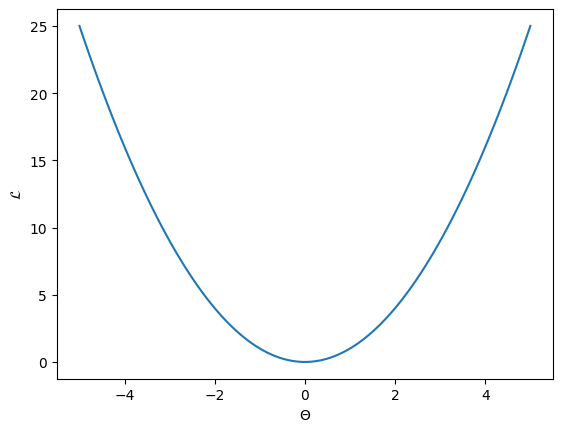

In [42]:
import matplotlib.pyplot as plt
import gif

# Define the target value. The number you want to guess
x = torch.tensor(0.0)
# Define the loss function
loss_fn = torch.nn.MSELoss()
# Define the range of theta values. The predictions
theta_space = torch.linspace(-5.0, 5.0, 100)
# Plot
plt.plot(theta_space, [loss_fn(_theta, x) for _theta in theta_space])
plt.xlabel("$ \Theta $")
plt.ylabel("$\mathcal{L}$")

In [43]:
theta = torch.tensor(5.0, requires_grad=True)
print(theta.item())

5.0


In [44]:
# Define the target
x = torch.tensor(0.0)
# Define the loss
loss_fn = torch.nn.MSELoss()

# Start off with a random theta value. This is your initial guess. We will update this using gradient descent
theta = torch.tensor(5.0, requires_grad=True)

# Store all the updates to theta and the loss function in lists
theta_trajectory = []
loss_trajectory = []

for _ in range(100):

    x_hat = theta
    # Append the current theta value to the theta_trajectory list
    theta_trajectory.append(theta.item())
    # Calculate the MSE loss. This is also a tensor
    loss = loss_fn(x, x_hat)
    # Compute the gradient of loss wrt theta
    loss.backward()
    # We can access dL/dtheta using theta.grad
    gradients = theta.grad

    # Let pass the gradient to our gradient_descent function to get the updated value of theta
    with torch.no_grad():
        theta = gradient_descent(theta, gradients, alpha=0.001)
        # We need to zero the gradients, otherwise they will continue to get accumulated in the buffer (i.e they are not overwritten)
        theta.grad.zero_()

    # Append the current loss value to the loss_trajectory list
    loss_trajectory.append(loss.item())


<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-838919691.py:9: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel("$ \Theta $")
/tmp/ipython-input-838919691.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mathcal{L}$")


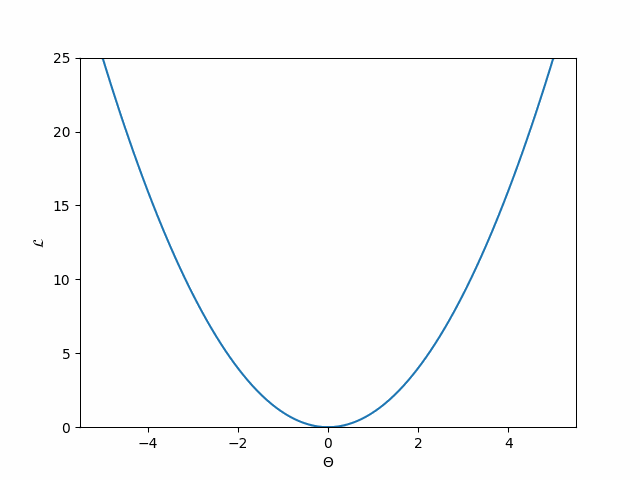

In [45]:
@gif.frame
def step(i):
    x = torch.tensor(0.0)
    loss_fn = torch.nn.MSELoss()
    theta_space = torch.linspace(-5.0, 5.0, 100)
    plt.clf()
    plt.plot(theta_space, [loss_fn(_theta, x) for _theta in theta_space])
    plt.plot(theta_trajectory[:i], loss_trajectory[:i], '-o')
    plt.xlabel("$ \Theta $")
    plt.ylabel("$\mathcal{L}$")
    plt.ylim(0, 25)

frames = [step(i) for i in range(100)]
gif.save(frames, "gradient_descent.gif", duration=10)
file_handle = open("gradient_descent.gif", "rb")
display.Image(file_handle.read(), format="png")

In [49]:
#Train a neural net on MNIST-Fashion Dataset
#1. Import dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

dataset_train = datasets.FashionMNIST("data", train=True, download=True, transform=ToTensor())
dataset_test = datasets.FashionMNIST("data", train=False, download=True, transform=ToTensor())


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.94MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 149kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.1MB/s]


In [50]:
# Different off the shelf datasets available on PyTorch
print(dir(datasets))

['CIFAR10', 'CIFAR100', 'CLEVRClassification', 'CREStereo', 'Caltech101', 'Caltech256', 'CarlaStereo', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'Country211', 'DTD', 'DatasetFolder', 'EMNIST', 'ETH3DStereo', 'EuroSAT', 'FER2013', 'FGVCAircraft', 'FakeData', 'FallingThingsStereo', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'Flowers102', 'FlyingChairs', 'FlyingThings3D', 'Food101', 'GTSRB', 'HD1K', 'HMDB51', 'INaturalist', 'ImageFolder', 'ImageNet', 'Imagenette', 'InStereo2k', 'KMNIST', 'Kinetics', 'Kitti', 'Kitti2012Stereo', 'Kitti2015Stereo', 'KittiFlow', 'LFWPairs', 'LFWPeople', 'LSUN', 'LSUNClass', 'MNIST', 'Middlebury2014Stereo', 'MovingMNIST', 'Omniglot', 'OxfordIIITPet', 'PCAM', 'PhotoTour', 'Places365', 'QMNIST', 'RenderedSST2', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SUN397', 'SVHN', 'SceneFlowStereo', 'Sintel', 'SintelStereo', 'StanfordCars', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', '__all__', '__builtins__', '__cached__',

In [51]:
print(f'Number of samples in train dataset : {len(dataset_train)}')
print(f'Number of samples in test dataset : {len(dataset_test)}')

Number of samples in train dataset : 60000
Number of samples in test dataset : 10000


In [52]:
print(dir(dataset_train))
dataset_train.classes
dataset_train.data.shape

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']


torch.Size([60000, 28, 28])

In [53]:
dataset_train.data.shape

torch.Size([60000, 28, 28])

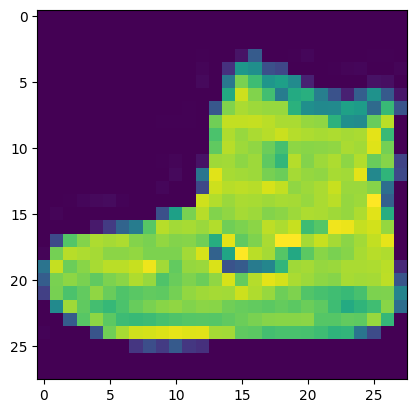

In [54]:
plt.imshow(dataset_train[0][0][0])

In [55]:
dataset_train.targets[0]

tensor(9)

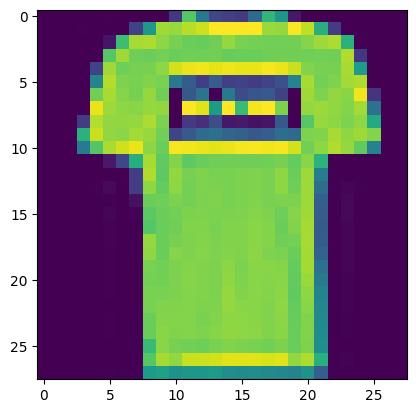

In [56]:
plt.imshow(dataset_train[1][0][0])

In [57]:
dataset_train.targets[0]

tensor(9)

In [58]:
from torch.utils.data import DataLoader
loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, pin_memory=True)
loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True, pin_memory=True)

In [59]:
#2. Creating pytorch dataset
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  # Create attributes for the CustomDataset class here
  def __init__(self, X):
    self.X = X

  # Optional. Returns the number of samples in the dataset
  def __len__(self):
    return X.shape[0]

  # Required. Should overwrite this method. This is how you fetch data from the dataset.
  def __getitem__(self, idx):
    return X[idx,:]


In [60]:
# Lets start off with a dummy dataset with 100 samples and 10 features(inputs)
X = torch.randn((100, 10))

# Pass it into our custom PyTorch Dataset class to create out custom_dataset object.
custom_dataset = CustomDataset(X)

In [61]:
# As before we can use the len() to find the number of samples in our dataset
len(custom_dataset)

100

In [62]:
# We can now pass custom_dataset into our DataLoader to create an iterable over our PyTorch Dataset.
custom_dataloader = DataLoader(custom_dataset, batch_size=10, shuffle=True)

In [63]:
# Now in our training and test loops we can easily access our batches.
for batch in custom_dataloader:
  # Just printing out the first batch here.
  print(batch.shape)
  break

torch.Size([10, 10])


In [64]:
#3. Define the neural net model
import torch
class Model(torch.nn.Module):

    # Define model layers here
    def __init__(self):
        super().__init__()
        self.fc0 = torch.nn.Linear(28*28, 16)
        self.fc1 = torch.nn.Linear(16, 16)
        self.fc2 = torch.nn.Linear(16, 10)

    # Define how the layers are connected here
    def forward(self, x):
        # Linear layers can only take 1D tensors as input so we need to flatten our images
        x = torch.nn.Flatten()(x)
        x = self.fc0(x)
        x = torch.nn.ReLU()(x)
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x

In [65]:
# We can view the layers used to build the model by just calling print(model)
model = Model()
print(model)

Model(
  (fc0): Linear(in_features=784, out_features=16, bias=True)
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)


In [66]:
# Model parameters can be accessed using the model.parameters() or model.named_parameters() function.
for parameter in model.named_parameters():
  layer_name, parameter_name = parameter[0].split('.')
  if parameter_name == 'weight':
    num_params = parameter[1].shape[0]*parameter[1].shape[1]
  else:
    num_params = parameter[1].shape[0]
  print(f'Layer {layer_name} {parameter_name} Shape : {parameter[1].shape} , Number of parameters :{num_params}')

Layer fc0 weight Shape : torch.Size([16, 784]) , Number of parameters :12544
Layer fc0 bias Shape : torch.Size([16]) , Number of parameters :16
Layer fc1 weight Shape : torch.Size([16, 16]) , Number of parameters :256
Layer fc1 bias Shape : torch.Size([16]) , Number of parameters :16
Layer fc2 weight Shape : torch.Size([10, 16]) , Number of parameters :160
Layer fc2 bias Shape : torch.Size([10]) , Number of parameters :10


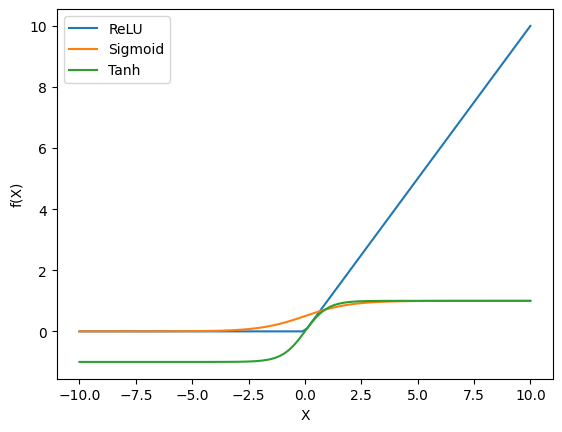

In [67]:
#more non-linear activation functions
import matplotlib.pyplot as plt
X = torch.linspace(-10,10,100)

def ReLU(X):
  return torch.clamp(X, min=0)

def sigmoid(X):
  return 1/(1 + torch.exp(-X))

def tanh(X):
  return (torch.exp(X) - torch.exp(-X))/(torch.exp(X) + torch.exp(-X))

plt.plot(X, ReLU(X), label='ReLU')
plt.plot(X, sigmoid(X), label='Sigmoid')
plt.plot(X, tanh(X), label='Tanh')
plt.ylabel('f(X)')
plt.xlabel('X')
plt.legend()
plt.show()

In [68]:
#4. Select optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


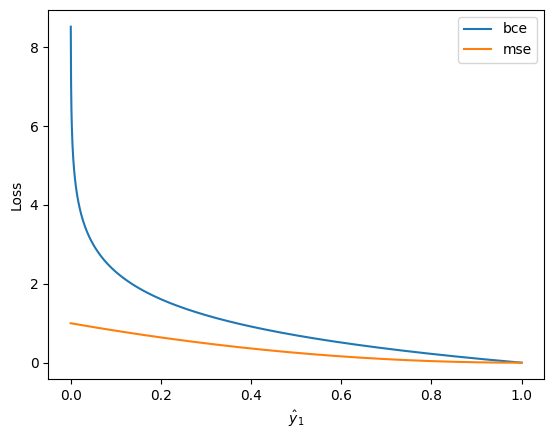

In [69]:
# In Biary cross entropy we have just 2 classes.
# For a given input lets assume it belongs to class 1. Then y1=1 and y2=0
# Lets vary the model predicted probability for class 1 (y1_hat) from 0 to 1 and observe how the losses for both BCE and MSE vary.
y1_hat = torch.linspace(0,1,5000, dtype=torch.float32)

y1 = torch.ones(y1_hat.shape[0])

def bce(y1_hat, y1):
  # Since we have
  return -y1*torch.log(y1_hat)

def mse(y1_hat, y1):
  return (y1 - y1_hat)**2

plt.plot(y1_hat, bce(y1_hat, y1), label='bce')
plt.plot(y1_hat, mse(y1_hat, y1), label='mse')
plt.xlabel(r'$\hat y_{1}$')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
# Instatntiate the cross entropy loss
ce = torch.nn.CrossEntropyLoss()

In [71]:
#5. Train model
model = Model()

if torch.cuda.is_available():
    model = model.cuda()

import tqdm # To show progress bar

for _ in tqdm.tqdm(range(10)):

    for x, y in loader_train:

        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()

        y_hat = model(x)

        loss = ce(y_hat, y)

        loss.backward()

        optimizer.step()

100%|██████████| 10/10 [01:17<00:00,  7.76s/it]


In [72]:
for x,y in loader_train:
  x = x.to('cuda')
  y_hat = model(x)
  break

In [73]:
y_hat.argmax(-1)

tensor([3, 3, 3, 0, 3, 9, 6, 9, 5, 6, 0, 3, 3, 3, 6, 0, 6, 9, 3, 9, 9, 3, 3, 9,
        3, 3, 3, 3, 3, 6, 3, 9, 0, 3, 3, 9, 9, 6, 3, 3, 3, 3, 6, 3, 3, 9, 9, 3,
        0, 3, 0, 3, 3, 9, 3, 9, 0, 3, 9, 3, 9, 0, 9, 3], device='cuda:0')

In [74]:
#6. Test model
# Calculate train accuracy
correct = 0
for x, y in loader_train:

    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()

    y_hat = model(x).argmax(-1)

    correct += (y_hat == y).sum().item()

accuracy_train = correct / len(loader_train.dataset)

# Calculate test accuracy
correct = 0
for x, y in loader_test:

    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()

    y_hat = model(x).argmax(-1)

    correct += (y_hat == y).sum().item()

accuracy_test = correct / len(loader_test.dataset)

print(f"Training accuracy {accuracy_train}, test accuracy {accuracy_test}.")

Training accuracy 0.14346666666666666, test accuracy 0.1434.


In [75]:
#Convolutional layer for better inductive bias
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=5)
        self.fc = torch.nn.Linear(3 * 3 * 32, 10)

    def forward(self, x):
        # Typical Stacking method : Conv2D -> MaxPool2D/AvgPool2D (for downsampling) -> Non linear activation

        x = self.conv1(x)
        x = torch.nn.ReLU()(x)

        x = self.conv2(x)
        x = torch.nn.MaxPool2d(2)(x)
        x = torch.nn.ReLU()(x)

        x = self.conv3(x)
        x = torch.nn.MaxPool2d(2)(x)
        x = x.flatten(-3, -1)

        x = self.fc(x)

        return x

In [76]:
model = Model()

if torch.cuda.is_available():
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), 1e-3)

import tqdm

for _ in tqdm.tqdm(range(10)):

    for x, y in loader_train:

        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()

        y_hat = model(x)

        loss = torch.nn.CrossEntropyLoss()(y_hat, y)

        loss.backward()

        optimizer.step()

100%|██████████| 10/10 [01:28<00:00,  8.82s/it]


In [77]:
correct = 0
for x, y in loader_train:
    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
    y_hat = model(x).argmax(-1)
    correct += (y_hat == y).sum().item()
accuracy_train = correct / len(loader_train.dataset)

correct = 0
for x, y in loader_test:
    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
    y_hat = model(x).argmax(-1)
    correct += (y_hat == y).sum().item()
accuracy_test = correct / len(loader_test.dataset)

print(f"Training accuracy {accuracy_train}, test accuracy {accuracy_test}.")

Training accuracy 0.9440833333333334, test accuracy 0.9009.
